In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc
import numpy as np
import pandas as pd

In [2]:
device = torch.device('cuda')

In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [4]:
full_dataset = datasets.ImageFolder(root='datasetji', transform=transform)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [6]:
from torchvision.models import VGG16_Weights
model = models.vgg16(weights=VGG16_Weights.IMAGENET1K_V1)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\prath/.cache\torch\hub\checkpoints\vgg16-397923af.pth
100%|██████████| 528M/528M [02:08<00:00, 4.30MB/s] 


In [7]:
for param in model.features.parameters():
    param.requires_grad = False

In [8]:
model.classifier = nn.Sequential(
    nn.Linear(25088, 4096),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(4096, 1024),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024, 2)  # 2 classes: Benign and Malignant
)

In [9]:
model = model.to(device)

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

In [11]:
num_epochs = 15
train_acc_hist = []
train_loss_hist = []
val_acc_hist = []
val_loss_hist = []


In [12]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    
    train_acc = correct / total
    train_loss = running_loss / len(train_loader)
    
    train_acc_hist.append(train_acc)
    train_loss_hist.append(train_loss)

    # Validation
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    val_acc = correct / total
    val_loss = running_loss / len(val_loader)

    val_acc_hist.append(val_acc)
    val_loss_hist.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

# Save final predictions
final_y_true = y_true
final_y_pred = y_pred

Epoch 1/15, Train Acc: 0.6386, Val Acc: 0.7356
Epoch 2/15, Train Acc: 0.7713, Val Acc: 0.7749
Epoch 3/15, Train Acc: 0.8585, Val Acc: 0.8704
Epoch 4/15, Train Acc: 0.9056, Val Acc: 0.9084
Epoch 5/15, Train Acc: 0.9312, Val Acc: 0.8953
Epoch 6/15, Train Acc: 0.9466, Val Acc: 0.8953
Epoch 7/15, Train Acc: 0.9571, Val Acc: 0.9123
Epoch 8/15, Train Acc: 0.9630, Val Acc: 0.9359
Epoch 9/15, Train Acc: 0.9695, Val Acc: 0.9123
Epoch 10/15, Train Acc: 0.9738, Val Acc: 0.9411
Epoch 11/15, Train Acc: 0.9741, Val Acc: 0.9424
Epoch 12/15, Train Acc: 0.9800, Val Acc: 0.9280
Epoch 13/15, Train Acc: 0.9846, Val Acc: 0.9385
Epoch 14/15, Train Acc: 0.9800, Val Acc: 0.9437
Epoch 15/15, Train Acc: 0.9839, Val Acc: 0.9398


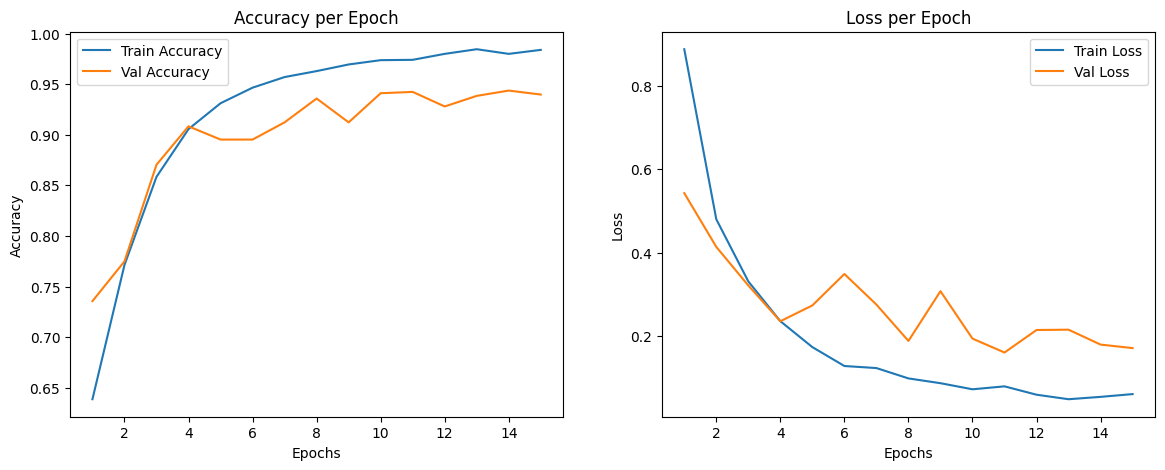

In [13]:
epochs = range(1, num_epochs+1)

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(epochs, train_acc_hist, label='Train Accuracy')
plt.plot(epochs, val_acc_hist, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, train_loss_hist, label='Train Loss')
plt.plot(epochs, val_loss_hist, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend()

plt.show()


In [14]:
df = pd.DataFrame({
    'Epoch': epochs,
    'Train Accuracy': train_acc_hist,
    'Validation Accuracy': val_acc_hist,
    'Train Loss': train_loss_hist,
    'Validation Loss': val_loss_hist,
})

print(df)


    Epoch  Train Accuracy  Validation Accuracy  Train Loss  Validation Loss
0       1        0.638598             0.735602    0.887730         0.542561
1       2        0.771298             0.774869    0.479894         0.413594
2       3        0.858453             0.870419    0.330829         0.321066
3       4        0.905636             0.908377    0.235406         0.235270
4       5        0.931193             0.895288    0.173204         0.273210
5       6        0.946592             0.895288    0.127884         0.348604
6       7        0.957077             0.912304    0.122943         0.275234
7       8        0.962975             0.935864    0.098117         0.188013
8       9        0.969528             0.912304    0.086655         0.307334
9      10        0.973788             0.941099    0.072042         0.193585
10     11        0.974115             0.942408    0.079086         0.160230
11     12        0.980013             0.928010    0.059028         0.214246
12     13   

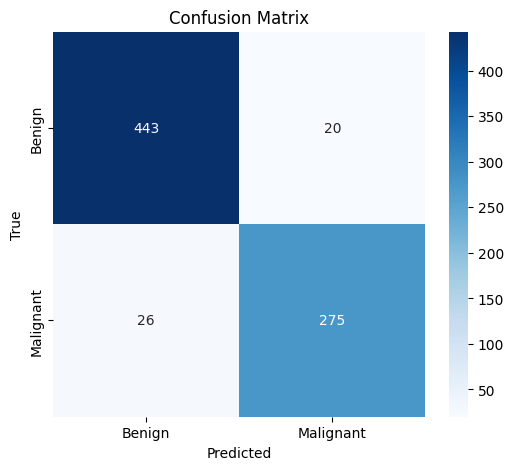

In [15]:
def plot_conf_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

plot_conf_matrix(final_y_true, final_y_pred)


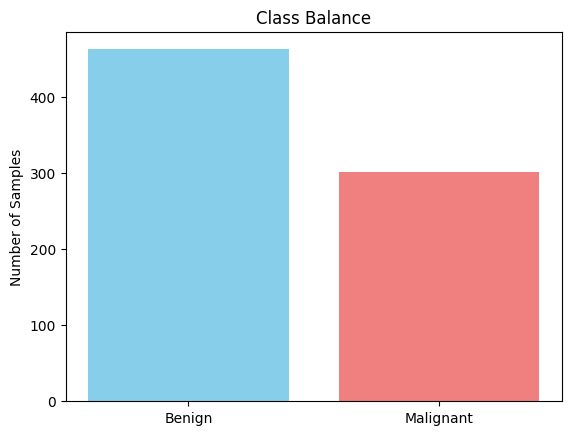

In [16]:
labels = ['Benign', 'Malignant']
class_counts = [np.sum(np.array(final_y_true)==0), np.sum(np.array(final_y_true)==1)]

plt.bar(labels, class_counts, color=['skyblue', 'lightcoral'])
plt.title('Class Balance')
plt.ylabel('Number of Samples')
plt.show()


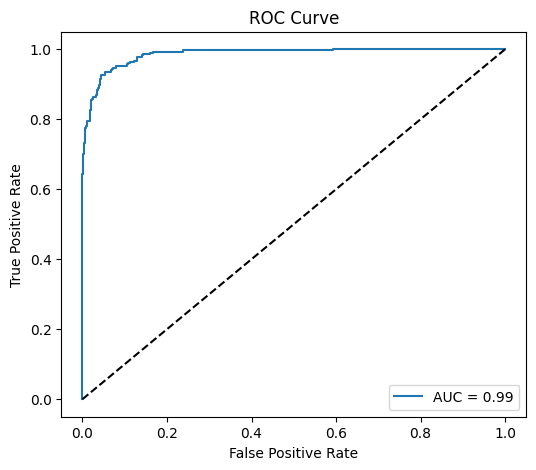

In [17]:
# Since we have two classes: use probability of class 1
model.eval()
y_probs = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)[:,1]  # Probability of malignant
        y_probs.extend(probs.cpu().numpy())

fpr, tpr, thresholds = roc_curve(final_y_true, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()
